# Preprocessing pipeline 

## Outline

<img src="static/preprocessing_pipeline_diagram.svg">

1. __Temporal filtering__

High-frequency artefacts and slow drifts are removed with a zero-phase bandpass filter 
using mne-Python [1]. 

2. __Segmenting the data__

Epochs are non-overlapping data segments created from the continuous data with a 
given duration.
Epochs can be created from (1) events; there is a custom method that created epochs 
based on annotations in the raw data, (2) without events, data segments are created 
from the beginning of the raw data. 

3. __Outlier data rejection__  

- _Preliminar rejection_

Epochs are rejected based on a global threshold on the z-score (> 3) of the epoch 
variance and amplitude range.

- _ICA decomposition_  

The default method is the infomax algorithm, however it can be changed in the 
configuration file along with the number of components and the decimation parameter. 
Components containing blink artefacts are automatically marked with mne-Python.
The ICA sourced can be visualized and interactively selected and rejected based on 
their topographies, time-courses or frequency spectra.

- _Autoreject_  

Autoreject [2, 3] uses unsupervised learning to estimate the rejection threshold for 
the epochs. In order to reduce computation time that increases with the number of 
segments and channels, autoreject can be fitted on a representative subset of epochs 
(25% of total epochs). Once the parameters are learned, the solution can be applied to 
any data that contains channels that were used during fit.

4. __Outlier channel interpolation__

The Random Sample Consensus (RANSAC) algorithm [4] selects a random subsample of good 
channels to make predictions of each channel in small non-overlapping 4 seconds long 
time windows. It uses a method of spherical splines (Perrin et al., 1989) to 
interpolate the bad sensors.


#### References

[1] A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013, ISSN 1662-453X

[2] Mainak Jas, Denis Engemann, Federico Raimondo, Yousra Bekhti, and Alexandre Gramfort, “Automated rejection and repair of bad trials in MEG/EEG.” In 6th International Workshop on Pattern Recognition in Neuroimaging (PRNI), 2016.

[3] Mainak Jas, Denis Engemann, Yousra Bekhti, Federico Raimondo, and Alexandre Gramfort. 2017. “Autoreject: Automated artifact rejection for MEG and EEG data”. NeuroImage, 159, 417-429.

[4] Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K. M., & Robbins, K. A. (2015). The PREP pipeline: standardized preprocessing for large-scale EEG analysis. Frontiers in neuroinformatics, 9, 16.



## Import packages


```%matplotlib qt``` is the recommended backend for interactive visualization (can be slower);    

switch to ```%matplotlib inline``` for faster but static plots

In [1]:
import os
from pathlib import Path

from ipyfilechooser import FileChooser
import pandas as pd

from meeg_tools.preprocessing import *
from meeg_tools.utils.epochs import create_epochs_from_events, create_metadata
from meeg_tools.utils.raw import read_raw_measurement, filter_raw, concat_raws_with_suffix
from meeg_tools.utils.log import update_log

%matplotlib qt

# Load raw data

See [this](https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html) documentation for help with supported file formats.  


If you have an error message with "Unsupported file type ['.vhdr']", then it means the file has been incorrectly renamed after creation. You should change it back to its original name and try reading it again.

In [2]:
# Use the widget to navigate to the experiment folder path and select an EEG file 
base_path = '/Users/weian/Downloads/Raw_data/'
fc = FileChooser(base_path)
fc.filter_pattern = ['*.vhdr', '*.edf']

display(fc)

FileChooser(path='/Users/weian/Downloads/Raw_data', filename='', title='', show_hidden=False, select_desc='Sel…

In [3]:
# Load selected file (when the data was recorded in one piece i.e. there is only one recording in the folder)
raw = read_raw_measurement(raw_file_path=fc.selected)

Extracting parameters from /Users/weian/Downloads/Raw_data/56_E/Day1/EEG/56_E_Day1.vhdr...
Setting channel info structure...
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 64 items (64 EEG)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2021-02-01 09:50:26 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 temp: 56_E_Day1
>


## Concatenate raw data

We can use this function when there was an issue with the recording and there are multiple EEG recordings for one measurement.


In [4]:
# note that we choose a folder and NOT a file name as before
#raws_folder_path = '/Users/weian/Downloads/EEG-3/'

# with the suffix argument we specify what kind of files to look for
#raw = concat_raws_with_suffix(path_to_raw_files=raws_folder_path, suffix='.vhdr')

In [ ]:
#raw.copy().crop(tmin=600, tmax=1200).plot()

## Select condition

The current logic for saving the preprocessed files is to create subfolders inside `base_path`,
with the name "preprocessed" and the name of the condition (e.g. "epochs_asrt", "epochs_rs").

In [4]:
condition = 'epochs_asrt'


# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
epochs_path = os.path.join(base_path, folder_name, condition)


# Create path to epoch files
if not os.path.exists(epochs_path):
    os.makedirs(epochs_path)
    
print(epochs_path)

/Users/weian/Downloads/Raw_data/preprocessed/epochs_asrt


### Load the log file if it already exists

We can check the list of preprocessed files by reading the log file within this notebook with `pandas`

In [5]:
os.listdir(epochs_path)

['log.csv',
 '.DS_Store',
 '17_E_Day1_ICA_autoreject_ransac-epo.fif.gz',
 '17_E_Day1_ICA-epo.fif.gz',
 '21_E_Day1_ICA-epo.fif.gz']

In [6]:
pd.read_csv(os.path.join(epochs_path, 'log.csv')) if 'log.csv' in os.listdir(epochs_path) else None

fid  highpass  lowpass  n_components  \
0                    17_E_Day1_ICA       0.5     45.0           1.0   
1         17_E_Day1_ICA_autoreject       0.5     45.0           1.0   
2  17_E_Day1_ICA_autoreject_ransac       0.5     45.0           1.0   
3  17_E_Day1_ICA_autoreject_ransac       0.5     45.0           1.0   
4                    21_E_Day1_ICA       0.5     45.0           2.0   

   n_bad_epochs  n_total_epochs  drop_percentage  \
0           106            1524             6.50   
1           405            1225            24.85   
2           405            1225            24.85   
3           405            1225            24.85   
4           134            1554             7.94   

                                stimuli  t_min  t_max  n_interpolated  \
0  ['10', '11', '12', '14', '15', '16']  -0.25   0.75             NaN   
1  ['10', '11', '12', '14', '15', '16']  -0.25   0.75             NaN   
2  ['10', '11', '12', '14', '15', '16']  -0.25   0.75             5.0   
3  ['10', '11', '12', '14', '15', '16']  -0.25   0.75             5.0   
4  ['10', '11', '12', '14', '15', '16']  -0.25   1.20             NaN   

   average_ref_applied  baseline  notes              date_of_update  
0                False       NaN    NaN  2022-02-09T12:24:54.346679  
1                False       NaN    NaN  2022-02-09T12:25:11.676597  
2                 True       NaN    NaN  2022-02-09T12:27:19.266813  
3                 True       NaN    NaN  2022-02-09T12:27:19.346322  
4                False       NaN    NaN  2022-02-09T15:18:56.927257

## Temporal filtering

We apply a bandpass filter on the continuous data using the `filter_raw` function.

The default parameters can be checked with `settings['bandpass_filter']`

In [7]:
settings["bandpass_filter"]

{'low_freq': 0.5, 'high_freq': 45}

In [8]:
raw_bandpass = filter_raw(raw=raw)

Reading 0 ... 3133649  =      0.000 ...  6267.298 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:   14.3s finished


## Create epochs

### A. Create epochs for event-related analysis

We create epochs from __selected__ events (stimuli) in the data.

Epochs are created with respect to the stimulus onset defined by `start_time` and 
`end_time` within `settings['epochs']`.

In [9]:
settings['epochs']

{'start_time': 0.0, 'end_time': 1.0, 'duration': 1}

In [10]:
settings['epochs']['start_time'] = -0.250
settings['epochs']['end_time'] = 1.2

In [11]:
events_ids = np.concatenate([np.arange(10, 53, 1), 
                             np.arange(10, 53, 1) + 100,
                            [211, 212, 213, 214, 215, 216]]) # boundaries of epochs

print(events_ids)

[ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 211 212 213 214
 215 216]


In [12]:
epochs = create_epochs_from_events(raw=raw_bandpass, event_ids=events_ids)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 17', 'Stimulus/S 18', 'Stimulus/S 19', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 24', 'Stimulus/S 25', 'Stimulus/S 26', 'Stimulus/S 27', 'Stimulus/S 28', 'Stimulus/S 29', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 34', 'Stimulus/S 35', 'Stimulus/S 36', 'Stimulus/S 37', 'Stimulus/S 38', 'Stimulus/S 39', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 43', 'Stimulus/S 44', 'Stimulus/S 45', 'Stimulus/S 46', 'Stimulus/S 47', 'Stimulus/S 48', 'Stimulus/S 49', 'Stimulus/S 51', 'Stimulus/S 52', 'Stimulus/S 61', 'Stimulus/S 62', 'Stimulus/S 63', 'Stimulus/S 64', 'Stimulus/S 65', 'Stimulus/S 66', 'Stimulus/S 67', 'Stimulus/S 68', 'Stimulus/S 69', 'Stimulus/S 70', 'Stimulus/S 71', 'Stimulus/S 72', 'Stimulus/S 75', 'Stimulus/S 76', 'Stimulus/S 77', 'Stimulus/S 78', 

In [23]:
#epochs["triplet == 'H'"].average().plot()

## Create metadata for epochs (optional)

- adding metadata makes it easier to select epochs of different types
- custom triggers are selected from the raw instance

- metadata can be added or replaced later (e.g. after preprocessing)

In [19]:
metadata = create_metadata(epochs=epochs)

# We have to assign it to the epochs instance to take effect
epochs.metadata = metadata

Found these indices for these epoch boundary events: 
211	1347
212	2688
213	4050
214	5392
215	6722
Adding metadata with 8 columns


In [20]:
# subselecting epochs 
# Here we could also include thrills, repetitions, or practice stimuli.
# ICA should not run on duplicate data (epochs should not be overlapping!)

epochs = epochs["triplet == 'L' | triplet == 'H'"]
epochs = epochs["answer == 'correct'"]

In [ ]:
#epochs.metadata.head()

In [ ]:
epochs[::7].plot()

## Run preprocessing


### 1.1. Preliminary epoch rejection

In [24]:
epochs_faster = prepare_epochs_for_ica(epochs=epochs)

Preliminary epoch rejection: 
Loading data for 1565 events and 726 original time points ...
0 bad epochs dropped
Bad epochs by amplitude
	[   9   69  139  162  201  251  258  320  359  454  539 1525 1527 1534
 1535 1540 1543 1545 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555
 1556 1557 1558 1560 1561 1562 1563 1564]
Bad epochs by deviation
	[ 139  162  454  630  749  933  934 1016 1074 1273]
Bad epochs by variance
	[1017 1032 1147 1277 1299 1525 1527 1532 1534 1535 1536 1540 1543 1545
 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557 1558 1559
 1560 1561 1562 1563 1564]
Dropped 51 epochs: 9, 69, 139, 162, 201, 251, 258, 320, 359, 454, 539, 630, 749, 933, 934, 1016, 1017, 1032, 1074, 1147, 1273, 1277, 1299, 1525, 1527, 1532, 1534, 1535, 1536, 1540, 1543, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564


In [23]:
#epochs_faster.plot_drop_log()

### 1.2. Run ICA


When visualizing the components, it is recommended to subset the data (see below).


Picard can be used to solve the same problems as FastICA, Infomax, and extended Infomax, but typically converges faster than either of those methods. To make use of Picard’s speed while still obtaining the same solution as with other algorithms, you need to specify method='picard' and fit_params as a dictionary with the following combination of keys:

dict(ortho=False, extended=False) for Infomax  

dict(ortho=False, extended=True) for extended Infomax  

dict(ortho=True, extended=True) for FastICA


In [25]:
settings["ica"]["method"] = 'picard'
settings["ica"]["decim"] = None

In [26]:
ica = run_ica(epochs_faster, fit_params=dict(ortho=False, extended=True))

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Loading data for 1514 events and 726 original time points ...


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Selecting by number: 32 components
Loading data for 1514 events and 726 original time points ...
Fitting ICA took 112.7s.
EOG channels are not found. Attempting to use Fp1,Fp2 channels as EOG channels.
Using EOG channels: Fp1, Fp2
Loading data for 1514 events and 726 original time points ...
Loading data for 1514 events and 726 original time points ...
Loading data for 1514 events and 726 original time points ...
Loading data for 1514 events and 726 original time points ...


In [28]:
# Plot component topographies
ica.plot_components()


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian

/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian

[<MNEFigure size 1950x1568 with 20 Axes>,
 <MNEFigure size 1950x1462 with 12 Axes>]

Loading data for 181 events and 726 original time points ...
Not setting metadata
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Using matplotlib as 2D backend.


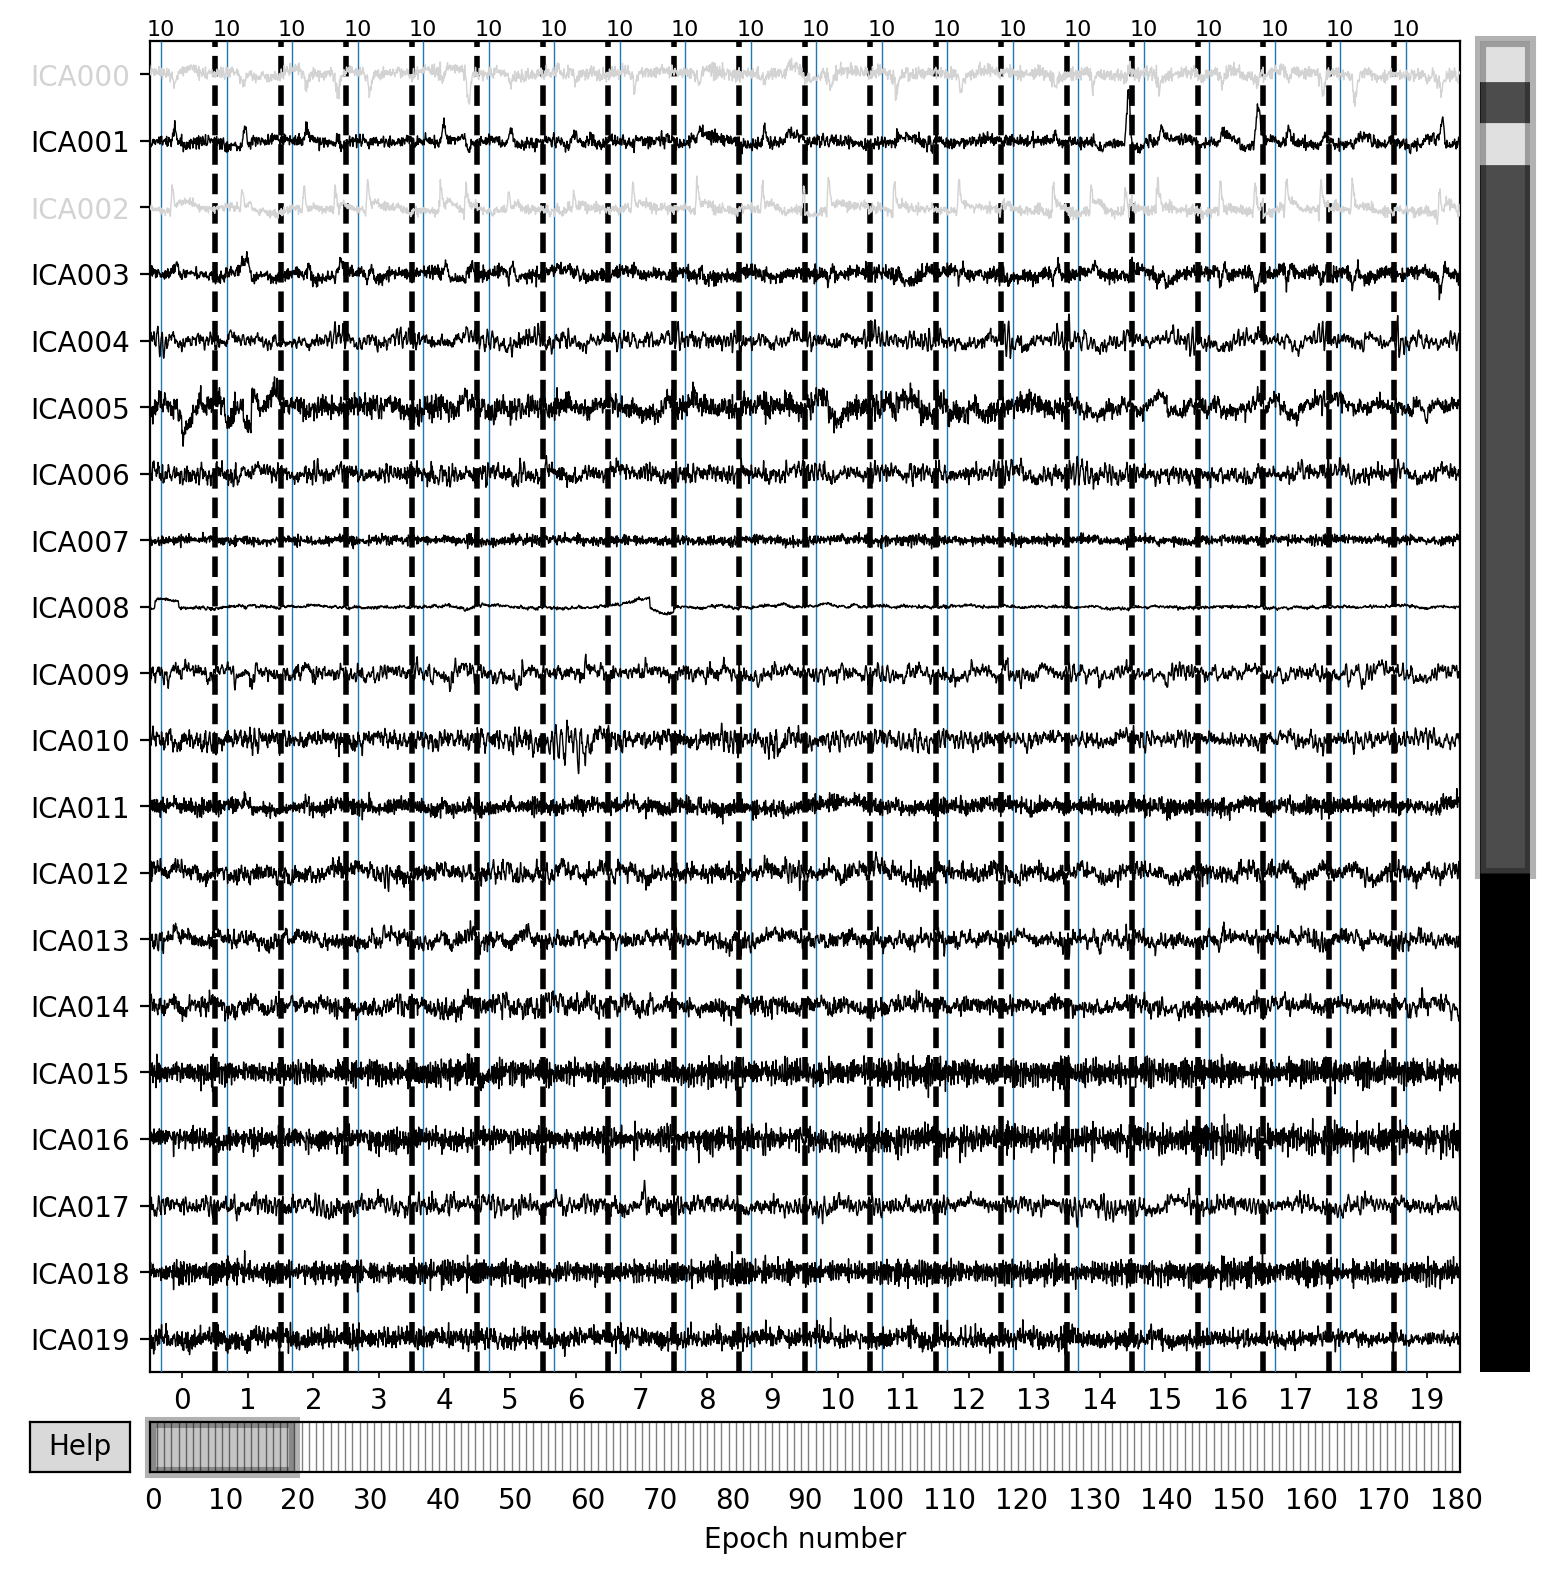

Loading data for 181 events and 726 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


In [27]:
# Visualize components on epochs
# Subset epochs to reduce execution time (e.g. take epochs from every 7th event)
subset = list(epochs.event_id.keys())[::7]
# Exclude components by selecting them, right click on component name to visualize source:
ica.plot_sources(epochs_faster[subset])

In [29]:
ica.exclude

[2, 1, 3, 0]

In [30]:
# After selecting the components to exclude, apply ICA to epochs
epochs_ica = apply_ica(epochs_faster, ica)

Loading data for 1514 events and 726 original time points ...
Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 4 ICA components
    Projecting back using 64 PCA components


In [30]:
print(epochs_ica.info)

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: False
 description: n_components: 2
 dig: 64 items (64 EEG)
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2021-01-14 14:33:24 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 temp: 21_E_Day1_ICA
>


### 1.3. Visualize ICA cleaned epochs (optional)

This step can be repeated after each preprocessing step, or you can also do a final inspection at the end. 


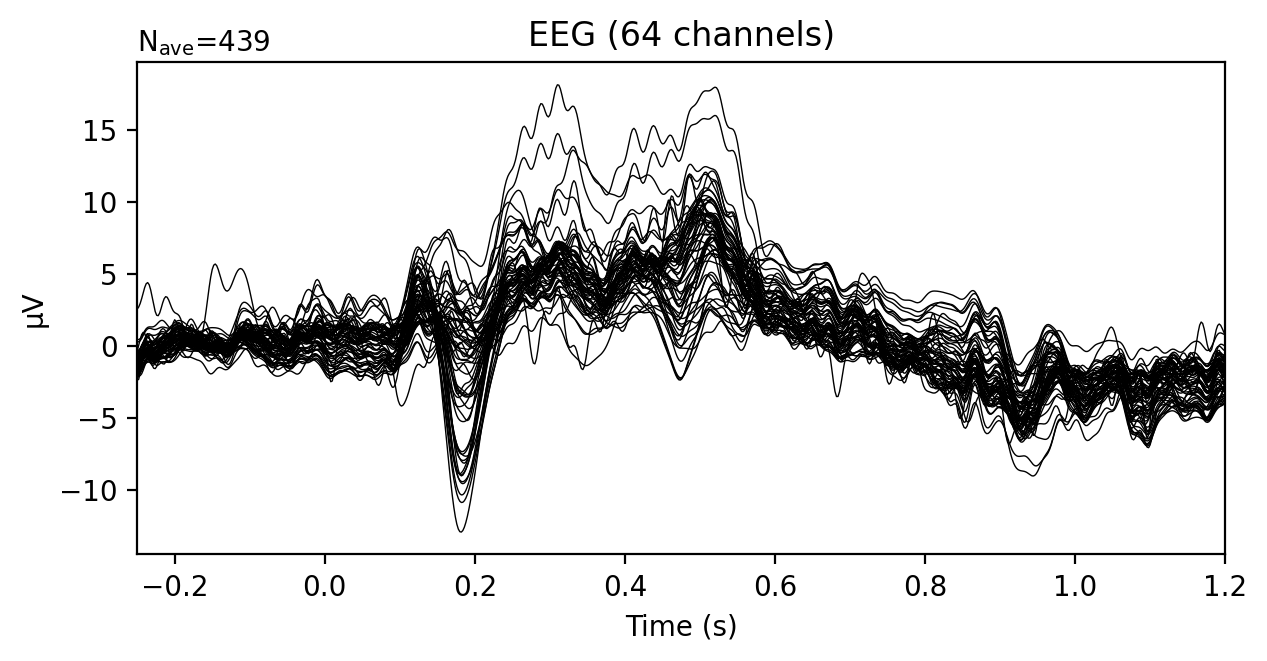

In [32]:
epochs_ica["triplet == 'L'"].average().plot()

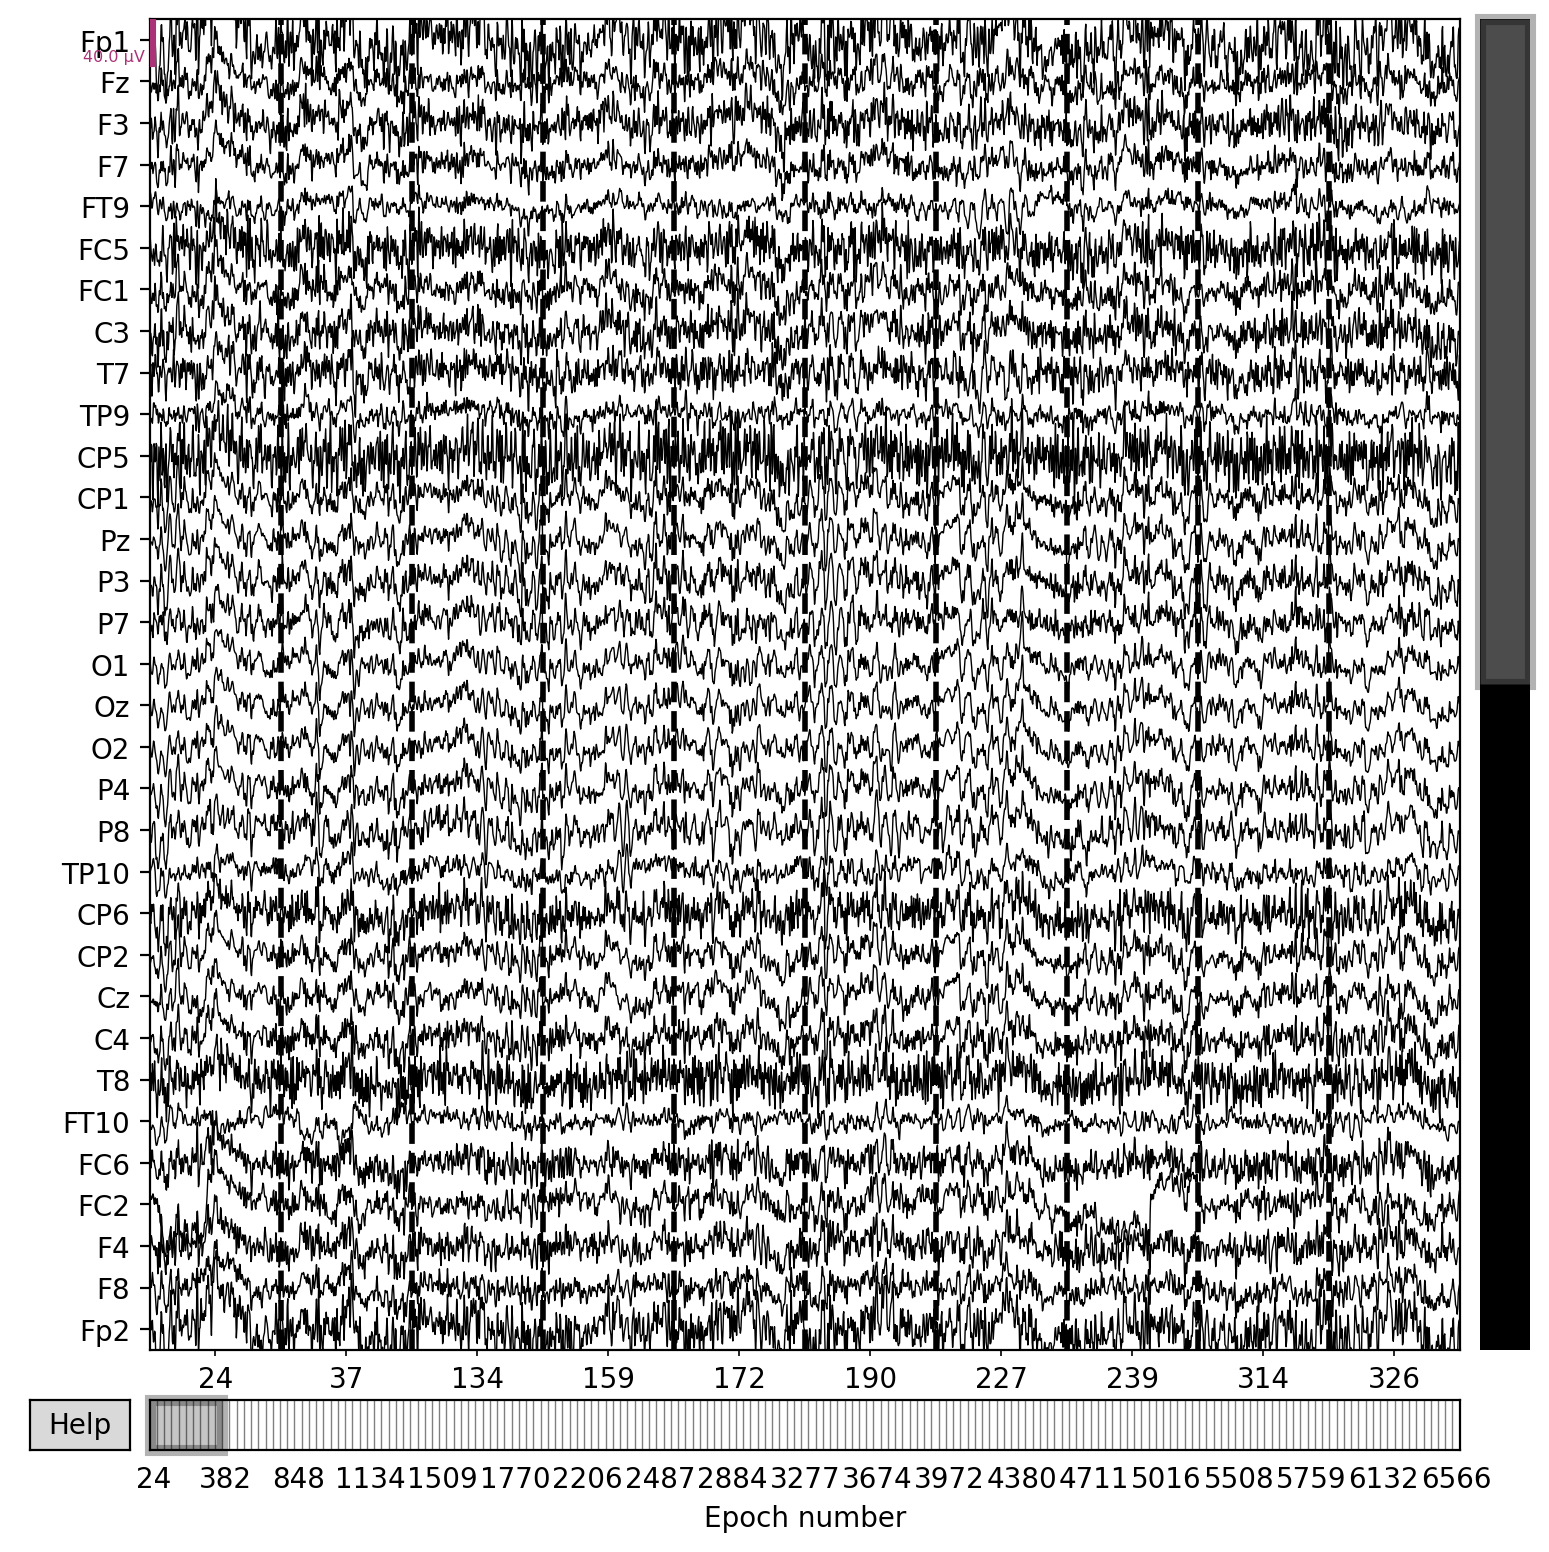

Dropped 0 epochs: 
Channels marked as bad: none


In [31]:
epochs_ica[subset].plot(n_epochs=10, n_channels=32, scalings={'eeg': 20e-6},)

### 1.4. Save cleaned epochs (recommended)

In [31]:
epochs_path

'/Users/weian/Downloads/Raw_data/preprocessed/epochs_asrt'

In [33]:
os.path.join(epochs_path, f'{epochs_ica.info["temp"]}-epo.fif.gz')

'/Users/weian/Downloads/Raw_data/preprocessed/epochs_asrt/21_E_Day1_ICA-epo.fif.gz'

In [34]:
epochs_ica.save(os.path.join(epochs_path, f'{epochs_ica.info["temp"]}-epo.fif.gz'),
                overwrite=True)

### 1.5. Create a log file 

We can create a log file for the preprocessed data and store metadata
that could be useful to remember. You can add more columns to this, or 
remove the ones that are not needed. For documentation purporses, it is 
recommended to store the number of rejected and total epochs, the number of
ICA components that were rejected, the number of interpolated electrodes etc.
You can also add a column with "notes" to add custom descriptions about the data.

In [35]:
notes = ''

In [36]:
log_file_path = os.path.join(os.path.join(epochs_path, 'log.csv'))

In [37]:
epochs_ica.info["temp"]

'21_E_Day1_ICA'

In [38]:
update_log(log_file_path, epochs_ica, notes)

fid  highpass  lowpass  n_components  n_bad_epochs  \
0  21_E_Day1_ICA       0.5     45.0           2.0           134   

   n_total_epochs  drop_percentage                   stimuli  t_min  t_max  \
0            1554             7.94  [10, 11, 12, 14, 15, 16]  -0.25    1.2   

   n_interpolated  average_ref_applied  baseline notes  \
0             NaN                False       NaN         

               date_of_update  
0  2022-02-09T15:18:56.927257

### 2.1. Run autoreject

In [41]:
reject_log = run_autoreject(epochs_ica, subset=True)

Fitting autoreject on random (n=388) subset of epochs: 
Running autoreject on ch_type=eeg


/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/Users/weian/.conda/envs/eeg-workshop/lib/python3.7/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/388 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/388 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/388 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/388 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.20 and n_interpolate=4

AUTOREJECT report
There are 8 bad epochs found with Autoreject. You can assess these epochs with reject_log.bad_epochs

There are 11 bad epochs where more than 15% of the channels were noisy. You can assess these epochs with reject_log.report


In [ ]:
reject_log.report

In [ ]:
# Here you can decide how strict should be the epoch rejection.
# You can drop only those that were marked as bad epochs, or a more 
# strict rejection threshold can be if you drop epochs where more than
# 15% of the channels were marked as noisy.

# You can plot the epochs with Autoreject, where bad epochs are marked with
# red colors. 

#reject_log.plot_epochs(epochs_faster)

In [42]:
epochs_autoreject = apply_autoreject(epochs=epochs_ica, reject_log=reject_log)

Dropped 11 epochs: 69, 71, 113, 653, 660, 672, 673, 770, 1124, 1215, 1496


In [ ]:
epochs_autoreject.info["temp"]

In [ ]:
os.path.join(epochs_path, f'{epochs_autoreject.info["temp"]}-epo.fif.gz')

In [ ]:
epochs_autoreject.save(os.path.join(epochs_path, f'{epochs_autoreject.info["temp"]}-epo.fif.gz'), overwrite=True)

In [37]:
# Update log
notes = ''

update_log(log_file_path, epochs_autoreject, notes)

fid  highpass  lowpass  n_components  n_bad_epochs  \
0  17_E_Day1_ICA_autoreject       0.5     45.0           1.0           405   

   n_total_epochs  drop_percentage                   stimuli  t_min  t_max  \
0            1225            24.85  [10, 11, 12, 14, 15, 16]  -0.25   0.75   

   n_interpolated  average_ref_applied  baseline notes  \
0             NaN                False       NaN         

               date_of_update  
0  2022-02-09T12:25:11.676597

### 3. Find and interpolate bad channels

In [43]:
bads = get_noisy_channels(epochs=epochs_autoreject, with_ransac=True)

Creating RawArray with float64 data, n_channels=64, n_times=1120218
    Range : 0 ... 1120217 =      0.000 ...  2240.434 secs
Ready.
Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!

NoisyChannels REPORT
------------------------
9.0% of the channels were detected as noisy.
(6) channels: Fp1, P8, T7, TP7, TP9, CP5


In [ ]:
#bads.extend(['T7', 'CPz'])

# .append() for string e.g. 'F7'
# .extend() for list ['F7', 'F8']

In [44]:
bads

['Fp1', 'P8', 'T7', 'TP7', 'TP9', 'CP5']

In [45]:
epochs_ransac = interpolate_bad_channels(epochs=epochs_autoreject, bads=bads)

Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 6 sensors


In [46]:
print(epochs_ransac.info)

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: False
 description: n_components: 2, interpolated: Fp1, P8, T7, TP7, TP9, CP5
 dig: 64 items (64 EEG)
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2021-01-14 14:33:24 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 temp: 21_E_Day1_ICA_autoreject_ransac
>


In [47]:
# Check how many trials are left for each condition per epoch
for i in range(5):
    print(i+1, epochs[f"epoch == {i+1}& triplet_type == 'HR'"].average().nave)

1 53
2 43
3 43
4 48
5 43


In [49]:
for i in range(5):
    print(i+1, epochs_ransac[f"epoch == {i+1}& triplet_type == 'HR'"].average().nave)

1 34
2 42
3 42
4 48
5 43


In [45]:
epochs_ransac.metadata

time_in_samples  stim  id  epoch triplet triplet_type   answer sequence
24             643786     0  16    1.0       L           LR  correct        A
27             644553     0  11    1.0       H            P  correct        A
30             645312     0  16    1.0       L           LR  correct        A
33             646080     0  11    1.0       H            P  correct        A
36             646839     0  10    1.0       H           HR  correct        A
...               ...   ...  ..    ...     ...          ...      ...      ...
6526          3097332     0  11    5.0       H            P  correct        A
6540          3100385     0  15    5.0       H            P  correct        A
6546          3101904     0  11    5.0       H            P  correct        A
6549          3102663     0  10    5.0       H           HR  correct        A
6560          3104973     0  11    5.0       H            P  correct        A

[1225 rows x 8 columns]

In [ ]:
# inspect which sensors were interpolated (if any)
print(epochs_ransac.info)

## 4. Final visual inspection

Mark epochs that should be dropped,  etc.

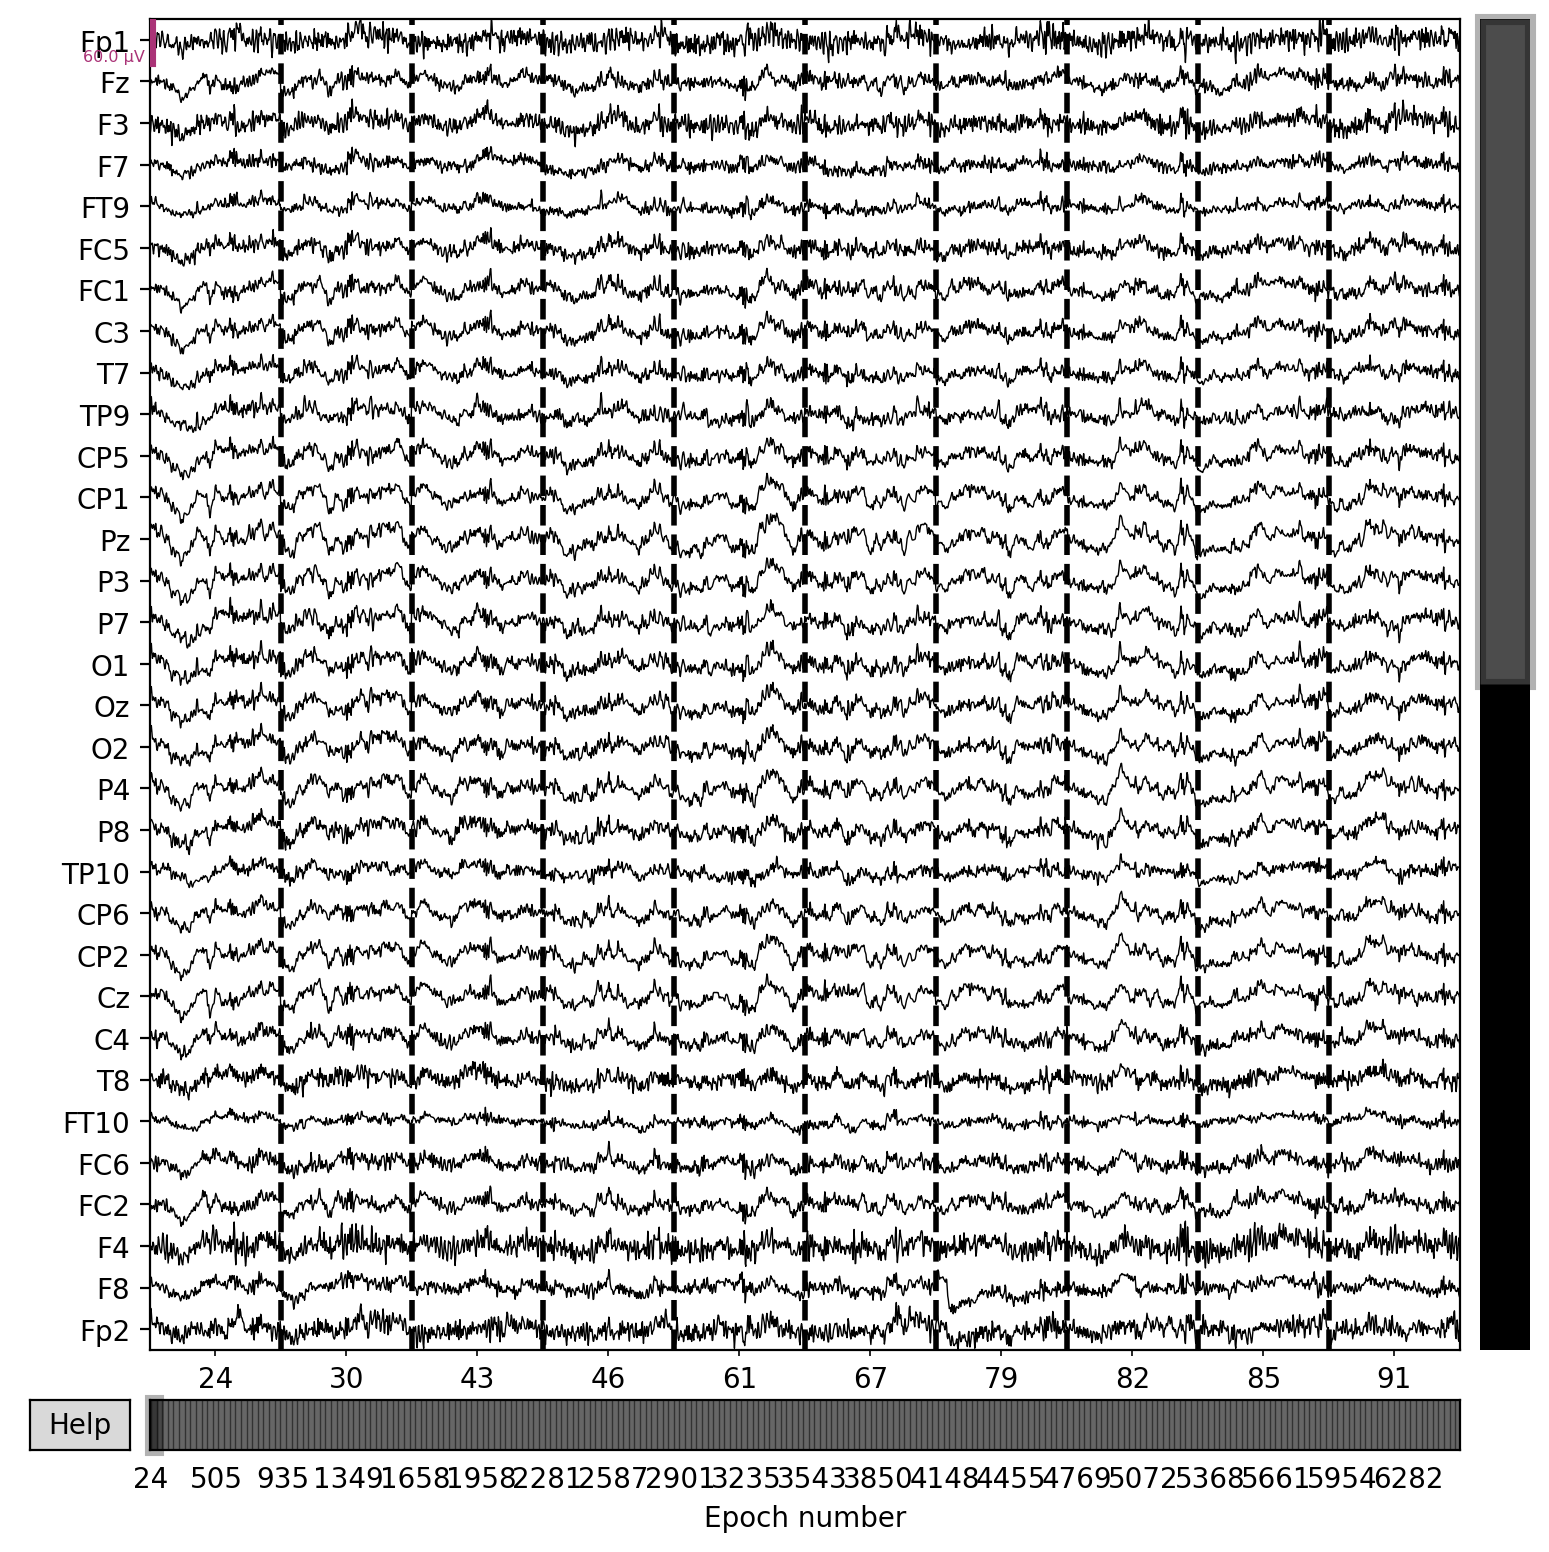

Dropped 0 epochs: 
Channels marked as bad: none


In [50]:
# # use indexing to plot fewer epochs (faster) e.g. [::7] shows only every 7th epoch
epochs_ransac.plot(n_epochs=10,
                       n_channels=32,
                # group_by='position',
                       scalings={'eeg': 30e-6})

### 5.2. Set average reference

To set a “virtual reference” that is the average of all channels, you can use set_eeg_reference() with ref_channels='average'.


In [46]:
epochs_ransac.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<Epochs |  1225 events (all good), -0.25 - 0.75 sec, baseline off, ~299.8 MB, data loaded, with metadata,
 '10': 130
 '11': 523
 '12': 128
 '14': 42
 '15': 175
 '16': 227>

## 6. Save cleaned epochs

In [47]:
os.path.join(epochs_path, f'{epochs_ransac.info["temp"]}-epo.fif.gz')

'/Users/weian/Downloads/Raw_data/preprocessed/epochs_asrt/17_E_Day1_ICA_autoreject_ransac-epo.fif.gz'

In [48]:
epochs_ransac.save(os.path.join(epochs_path, f'{epochs_ransac.info["temp"]}-epo.fif.gz'), overwrite=True)

In [50]:
update_log(log_file_path, epochs_ransac, '')

fid  highpass  lowpass  n_components  \
0  17_E_Day1_ICA_autoreject_ransac       0.5     45.0           1.0   

   n_bad_epochs  n_total_epochs  drop_percentage                   stimuli  \
0           405            1225            24.85  [10, 11, 12, 14, 15, 16]   

   t_min  t_max  n_interpolated  average_ref_applied  baseline notes  \
0  -0.25   0.75             5.0                 True       NaN         

               date_of_update  
0  2022-02-09T12:27:19.346322

In [ ]:
epochs.plot_sensors(show_names=True)

In [51]:
ch_names = ['F7', 'F5', 'F3', 'FC5', 'FC3',
           'F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2',
           'F4', 'F6', 'F8', 'FC4', 'FC6',
           'FT7', 'T7', 'TP7', 
           'C3', 'Cz', 'C4',
           'FT8', 'T8', 'TP8',
           'CP5', 'CP3', 'P7', 'P5', 'P3',
           'CP1', 'CPz', 'CP2', 'P1', 'Pz', 'P2',
           'CP4', 'CP6', 'P4', 'P6', 'P8',
           'PO3', 'PO7', 'O1',
           'PO4', 'PO8', 'O2',]


epochs_evoked = epochs_ransac.copy().pick_channels(ch_names, ordered=True)

    Using multitaper spectrum estimation with 7 DPSS windows


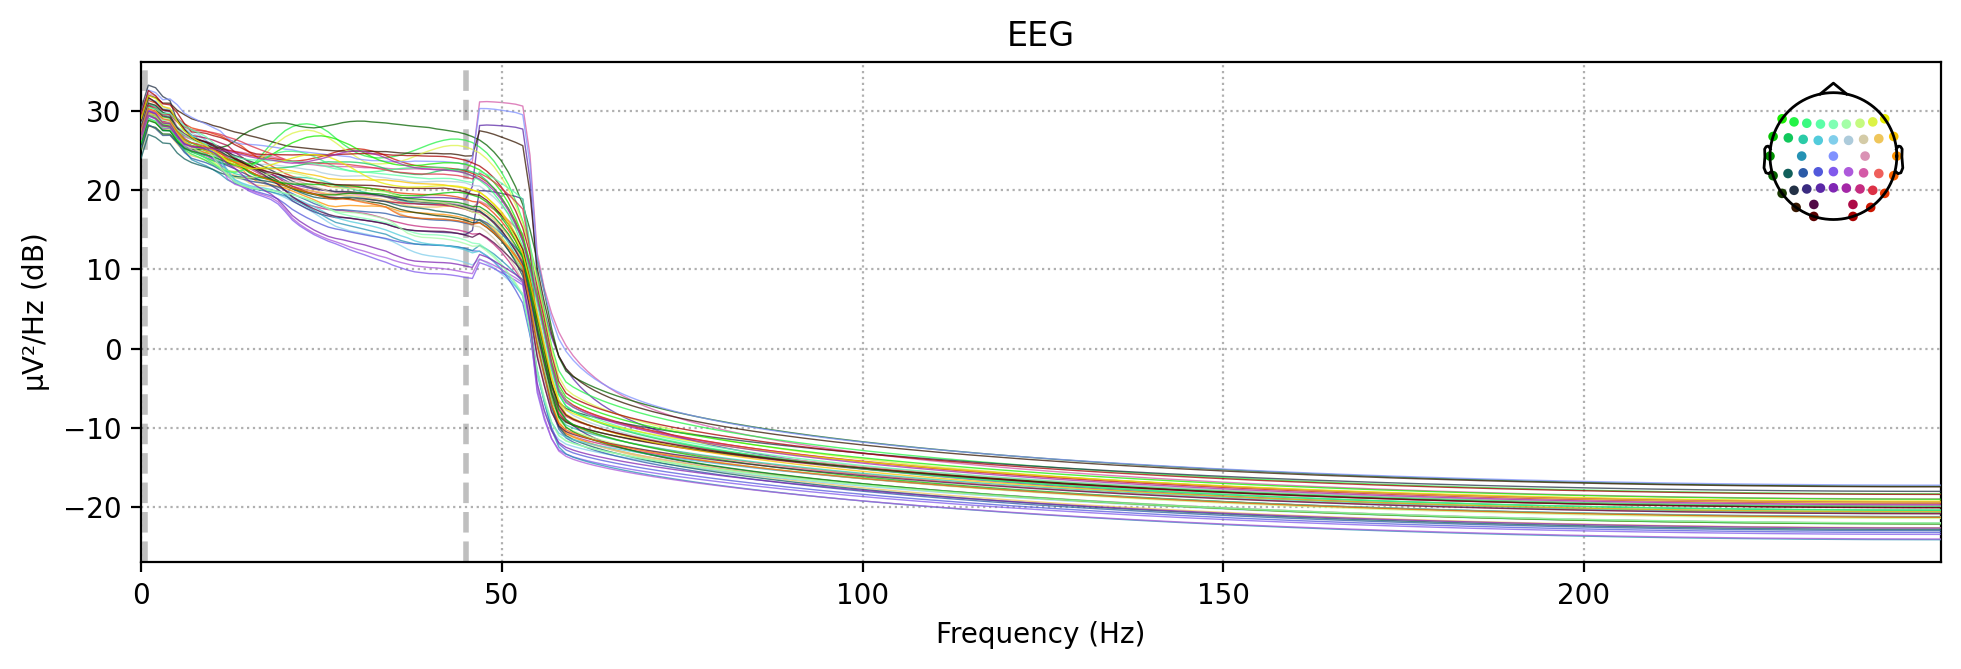

In [52]:
epochs_evoked.plot_psd() # set fmin fmax

In [ ]:
e1_H = epochs_evoked["epoch == 1 & triplet == 'H'"].average()
e1_H.apply_baseline((-0.2, 0.0))
#e1_H.comment = f"{epochs_evoked.comment}_e1_H"

e1_H.plot('F8', spatial_colors=True)